In [43]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, cross_validation
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.metrics import roc_curve, auc
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
fb_df = pd.read_csv('fb_tweets_stock.csv', index_col = 0)

In [39]:
target = fb_df['up_down']
X = fb_df.loc[:, fb_df.columns != 'up_down']
X = X.drop(['day'], axis = 1)

In [6]:
# normalize the data
def normalize(column):
    minimum = X[column].min()
    maximum = X[column].max()
    diff = maximum - minimum
    norm = (X[column] - minimum) / diff
    return norm

In [40]:
for column in list(X.columns):
    X[column] = normalize(column)

In [45]:
# tuning the weight using SMOTE
print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

0    30
1    22
Name: up_down, dtype: int64
1    30
0    30
dtype: int64


In [46]:
def test_set(X, Y) :
    data_train, data_test, target_train, target_test = train_test_split(X, Y)
    logreg = LogisticRegression()
    logreg.fit(data_train, target_train)
    predict_train = logreg.predict(data_train)
    predict_test = logreg.predict(data_test)
    print('train set accuracy: ' + str(metrics.accuracy_score(predict_train, target_train)))
    print('test set accuracy: ' + str(metrics.accuracy_score(predict_test, target_test)))
    print(metrics.classification_report(predict_test, target_test))

test_set(X_resampled, y_resampled)

## cross validation
def k_fold(X, Y, cv = 10):
    predicted = cross_validation.cross_val_predict(LogisticRegression(), X, Y, cv=cv)
    print(metrics.accuracy_score(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))
    print(metrics.classification_report(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))

k_fold(X_resampled, y_resampled, cv = 10)

## Confusion Matrix for 
## ROC for all the 

train set accuracy: 0.9555555555555556
test set accuracy: 0.6
             precision    recall  f1-score   support

          0       0.50      0.67      0.57         6
          1       0.71      0.56      0.63         9

avg / total       0.63      0.60      0.60        15

0.6833333333333333
             precision    recall  f1-score   support

          0       0.60      0.72      0.65        25
          1       0.77      0.66      0.71        35

avg / total       0.70      0.68      0.69        60



LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for l1: 0.7037037037037037
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for l2: 0.7592592592592593


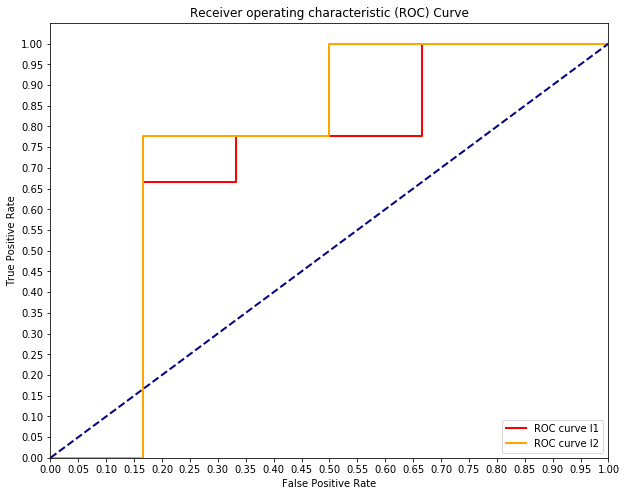

In [47]:
# LASSO Ridge
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)

for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, penalty=pen) #Starter code
    model_log = logreg.fit(data_train, target_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(data_test)

    y_score = logreg.fit(data_train, target_train).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, y_score)
    
    print('AUC for {}: {}'.format(str(pen), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_feature_importances(model):
    n_features = df2.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), df2.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest)